In [13]:
print("hello world")

hello world


In [22]:
from langgraph.graph import StateGraph, START, END
import os

In [25]:
from langchain_openai import OpenAI, ChatOpenAI

In [26]:
from dotenv import load_dotenv
load_dotenv()

True

In [27]:
openai_api_key = os.getenv("OPENAI_API_KEY")

In [28]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    api_key=openai_api_key
)

In [19]:
#llm.invoke("Hello how are you?")

In [20]:
from typing_extensions import TypedDict
from typing import Annotated, Dict, Any
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langchain_core.messages import AIMessage
import requests

In [21]:
# Minimal State
class State(TypedDict):
    messages: Annotated[list, add_messages]
    data: Dict[str, Any]

In [22]:
FLOWS = {
    "insertion_in_db": "https://prod-02.centralindia.logic.azure.com:443/workflows/176b9969d13147aa90ae97d9b53c7ca9/triggers/manual/paths/invoke?api-version=2016-06-01&sp=%2Ftriggers%2Fmanual%2Frun&sv=1.0&sig=cRltkx9lLIr5KRfxpNBvPZcmp2ybs3uxpSM_EvYk42s",
    "doc_download":"https://prod-16.centralindia.logic.azure.com:443/workflows/e8c18012e313410dae07e6ed20ccc816/triggers/manual/paths/invoke?api-version=2016-06-01&sp=%2Ftriggers%2Fmanual%2Frun&sv=1.0&sig=oMl04_zC72XGN8W-ChrED9jW4pvSs5xUEQQA0BuHs3E"
}

In [23]:
def call_flow(flow_name: str, data: dict) -> dict:
    """Call Power Automate flow"""
    try:
        response = requests.post(FLOWS[flow_name])
        return {"success": True}
    except Exception as e:
        return {"success": False, "error": str(e)}
    
def insertion_in_db(state: State):
    result = call_flow("insertion_in_db", state["data"])
    return {
        "messages": [AIMessage(content=f"DB insertion: {'✅' if result['success'] else '❌'}")],
        "data": {**state["data"], "db_result": result}
    }

def doc_download(state: State):
    result = call_flow("doc_download", state["data"])
    return {
        "messages": [AIMessage(content=f"Document download: {'✅' if result['success'] else '❌'}")],
        "data": {**state["data"], "doc_result": result}
    }

In [24]:
def create_pipeline():
    graph = StateGraph(State)
    graph.add_node("insertion_in_db", insertion_in_db)
    graph.add_node("doc_download", doc_download)
    graph.set_entry_point("insertion_in_db")
    graph.add_edge("insertion_in_db", "doc_download")
    graph.add_edge("doc_download", END)
    
    return graph.compile()

In [25]:
def run():
    pipeline = create_pipeline()
    result = pipeline.invoke({"messages": [], "data": {"pipeline_id": "test_001"}})
    
    print("Pipeline completed!")
    for msg in result["messages"]:
        print(f"  {msg.content}")
    
    return result

In [26]:
def visualize():
    pipeline = create_pipeline()
    try:
        from IPython.display import Image, display
        display(Image(pipeline.get_graph().draw_mermaid_png()))
    except Exception:
        print(pipeline.get_graph().draw_mermaid())


Pipeline completed!
  DB insertion: ✅
  Document download: ✅


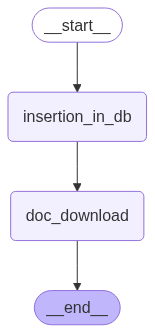

In [27]:
run()
visualize()


In [ ]:
import pyodbc
DATABASE = "Agentic_Automation"
conn_str = (
    "DRIVER={SQL Server};"
    "SERVER=216.48.191.98;"
    f"DATABASE={DATABASE};"
    "UID=ibsadmin;"
    "PWD=Viking@@ibs2023;"
)
cnxn = pyodbc.connect(conn_str, autocommit=True)
cursor = cnxn.cursor()

In [73]:
#### main testing file###
from typing_extensions import TypedDict
from typing import Annotated, Dict, Any
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langchain_core.messages import AIMessage
import requests
import time
import pyodbc
from contextlib import closing

# 1) Define the shape of the pipeline state
class State(TypedDict):
    messages: Annotated[list, add_messages]
    data: Dict[str, Any]

# 2) Your two Power Automate endpoints
FLOWS = {
    "insertion_in_db": "https://prod-02.centralindia.logic.azure.com:443/workflows/176b9969d13147aa90ae97d9b53c7ca9/triggers/manual/paths/invoke?api-version=2016-06-01&sp=%2Ftriggers%2Fmanual%2Frun&sv=1.0&sig=cRltkx9lLIr5KRfxpNBvPZcmp2ybs3uxpSM_EvYk42s",
    "doc_download": "https://prod-16.centralindia.logic.azure.com:443/workflows/e8c18012e313410dae07e6ed20ccc816/triggers/manual/paths/invoke?api-version=2016-06-01&sp=%2Ftriggers%2Fmanual%2Frun&sv=1.0&sig=oMl04_zC72XGN8W-ChrED9jW4pvSs5xUEQQA0BuHs3E"
}

def call_flow(flow_name: str, data: dict) -> dict:
    """Trigger a Power Automate flow and report success/failure."""
    try:
        resp = requests.post(FLOWS[flow_name], json=data)
        resp.raise_for_status()
        return {"success": True}
    except Exception as e:
        return {"success": False, "error": str(e)}

def insertion_in_db(state: State) -> State:
    result = call_flow("insertion_in_db", state["data"])
    print(f"DB insertion result: {result}")
    return {
        "messages": [
            AIMessage(f"DB insertion: {'✅' if result['success'] else '❌'}")
        ],
        "data": state["data"]
    }

def wait_for_status_dbinsertion(state: State) -> State:
    """Poll the workflow_status table until status == 'Completed'."""
    conn_str = (
        "DRIVER={SQL Server};"
        "SERVER=216.48.191.98;"
        "DATABASE=Agentic_Automation;"
        "UID=ibsadmin;"
        "PWD=Viking@@ibs2023;"
    )
    query = """
        SELECT DbInsertion
        FROM [Agentic_Automation].[dbo].[workflow_status]
        WHERE WebtopId = ?
    """
    webtop_id = state["data"]["WebtopId"]

    with pyodbc.connect(conn_str, autocommit=True) as conn:
        with closing(conn.cursor()) as cur:
            while True:
                cur.execute(query, webtop_id)
                row = cur.fetchone()
                if row and row[0] == "Completed":
                    break
                time.sleep(5)
    print("DB status: Completed")
    return {
        "messages": [AIMessage("DB status: ✅ Completed")],
        "data": state["data"]
    }

def wait_for_status_docdownload(state: State) -> State:
    """Poll the workflow_status table until status == 'Completed'."""
    conn_str = (
        "DRIVER={SQL Server};"
        "SERVER=216.48.191.98;"
        "DATABASE=Agentic_Automation;"
        "UID=ibsadmin;"
        "PWD=Viking@@ibs2023;"
    )
    query = """
        SELECT DocDownload
        FROM [Agentic_Automation].[dbo].[workflow_status]
        WHERE WebtopId = ?
    """
    webtop_id = state["data"]["WebtopId"]

    with pyodbc.connect(conn_str, autocommit=True) as conn:
        with closing(conn.cursor()) as cur:
            while True:
                cur.execute(query, webtop_id)
                row = cur.fetchone()
                if row and row[0] == "Completed":
                    break
                time.sleep(5)
    print("Doc download status: Completed")

    return {
        "messages": [AIMessage("DB status: ✅ Completed")],
        "data": state["data"]
    }



def doc_download(state: State) -> State:
    result = call_flow("doc_download", state["data"])
    print(f"Document download result: {result}")
    return {
        "messages": [
            AIMessage(f"Document download: {'✅' if result['success'] else '❌'}")
        ],
        "data": {**state["data"], "doc_result": result}
    }

def create_pipeline():
    graph = StateGraph(State)
    graph.add_node("insertion_in_db", insertion_in_db)
    graph.add_node("wait_for_status_dbinsertion",  wait_for_status_dbinsertion)
    graph.add_node("doc_download",     doc_download)
    graph.add_node("wait_for_status_docdownload", wait_for_status_docdownload)

    graph.set_entry_point("insertion_in_db")
    graph.add_edge("insertion_in_db", "wait_for_status_dbinsertion")
    graph.add_edge("wait_for_status_dbinsertion", "doc_download")
    graph.add_edge("doc_download", "wait_for_status_docdownload")
    graph.add_edge("wait_for_status_docdownload", END)

    return graph.compile()

if __name__ == "__main__":
    pipeline = create_pipeline()
    # seed the pipeline with an ID of your workflow run
    result = pipeline.invoke({
        "messages": [],
        "data": {"WebtopId": "ABC123"}
    })
    print("Pipeline completed, messages:")
    for msg in result["messages"]:
        print(" •", msg.content)


DB insertion result: {'success': True}
DB status: Completed
Document download result: {'success': True}
Doc download status: Completed
Pipeline completed, messages:
 • DB insertion: ✅
 • DB status: ✅ Completed
 • Document download: ✅
 • DB status: ✅ Completed


In [ ]:
def visualize():
    pipeline = create_pipeline()
    try:
        from IPython.display import Image, display
        display(Image(pipeline.get_graph().draw_mermaid_png()))
    except Exception:
        print(pipeline.get_graph().draw_mermaid())


In [ ]:
def create_pipeline():
    graph = StateGraph(State)
    graph.add_node("insertion_in_db", insertion_in_db)
    graph.add_node("wait_for_status_dbinsertion",  wait_for_status_dbinsertion)
    graph.add_node("doc_download",     doc_download)
    graph.add_node("wait_for_status_docdownload", wait_for_status_docdownload)

    graph.set_entry_point("insertion_in_db")
    graph.add_edge("insertion_in_db", "wait_for_status_dbinsertion")
    graph.add_edge("wait_for_status_dbinsertion", "doc_download")
    graph.add_edge("doc_download", "wait_for_status_docdownload")
    graph.add_edge("wait_for_status_docdownload", END)

    return graph.compile()


In [ ]:
def visualize():
    pipeline = create_pipeline()
    try:
        from IPython.display import Image, display
        display(Image(pipeline.get_graph().draw_mermaid_png()))
    except Exception:
        print(pipeline.get_graph().draw_mermaid())
visualize()


In [ ]:
import pyodbc
DATABASE = "Agentic_Automation"
conn_str = (
    "DRIVER={SQL Server};"
    "SERVER=216.48.191.98;"
    f"DATABASE={DATABASE};"
    "UID=ibsadmin;"
    "PWD=Viking@@ibs2023;"
)
cnxn = pyodbc.connect(conn_str, autocommit=True)
cursor = cnxn.cursor()

In [ ]:
from langchain_core.tools import tool
from langchain.agents import tool
from langchain.agents import initialize_agent, AgentType

In [37]:
@tool
def dbinsertion()-> str:
    """Insert the records into database"""
    return "Database Insertion: Completed"
@tool
def docdownload()-> str:
    """Downloads the documents required for the process"""
    return "Document Download: Completed"
@tool
def crmscraping()-> str:
    """Gets required data for the CRM system"""
    return "CRM Scraping: Completed"

@tool
def documentextraction()-> str:
    """Extracts the required data from the documents"""
    return "Document Extraction: Completed"

@tool
def externalchecks()-> str:
    """Performs external checks apart for the process"""
    return "External Checks: Completed"

@tool
def internalchecks()-> str:
    """Performs internal checks apart for the process"""
    return "External Checks: Completed"

@tool 
def mastervalidation()-> str:
    """Validates the master data for the process"""
    return "Master Validation: Completed"

@tool
def resultvisualization()-> str:
    """Generates the credit assessment summary for the process"""
    return "Result Generation: Completed"

In [ ]:
import pyodbc
DATABASE = "Agentic_Automation"
conn_str = (
    "DRIVER={SQL Server};"
    "SERVER=216.48.191.98;"
    f"DATABASE={DATABASE};"
    "UID=ibsadmin;"
    "PWD=Viking@@ibs2023;"
)
cnxn = pyodbc.connect(conn_str, autocommit=True)
cursor = cnxn.cursor()

In [38]:
tools = [
    dbinsertion,
    docdownload,
    crmscraping,
    documentextraction,
    externalchecks,
    internalchecks,
    mastervalidation,
    resultvisualization
]

In [ ]:
llm = ChatOpenAI(model_name="gpt-4o-mini")


if __name__ == "__main__":
    user_prompt = (
        "Please download the documents, extract data, run external checks, "
        "and insert into the database."
    )
    output = agent.run(user_prompt)
    print("Agent Output:\n", output)

ValueError: ZeroShotAgent does not support multi-input tool dbinsertion.

In [30]:
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage, SystemMessage
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[Sequence[AnyMessage], add_messages]

In [6]:
state=State()

In [10]:
state={"messages":[
    HumanMessage(content="Hello!"),
    AIMessage(content="Hi there! How can I help you today?"),
    HumanMessage(content="Myself Shubham"),
    AIMessage(content="Hi Shubham! Myself AI"),
    HumanMessage(content="Can you please tell me a joke?"),
    AIMessage(content="Sure! Why did the scarecrow win an award? Because he was outstanding in his field!"),
    HumanMessage(content="Haha very funny!"),
    AIMessage(content="Is there anything else I can help you with?"),
    HumanMessage(content="No, that's all for now. Thanks!"),
    AIMessage(content="Seya!"),
]}

In [11]:

answer=state["messages"][-1]
type(answer)

langchain_core.messages.ai.AIMessage

In [16]:
print(state["messages"][0])

content='Hello!' additional_kwargs={} response_metadata={}


In [31]:
state2=State()
print(state2)

{}


In [ ]:
from typing import TypedDict, Annotated, List
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
import os
from dotenv import load_dotenv

# 0) Setup LLM
load_dotenv()
llm = ChatOpenAI(
    model_name="gpt-4o-mini",
    temperature=0.0,
    openai_api_key=os.getenv("OPENAI_API_KEY"),
)

from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage, SystemMessage
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[Sequence[AnyMessage], add_messages]


state: State = {"messages": []}
while True:
    user_input = input("Please enter your input: ")
    if user_input.strip().lower() == "exit":
        print("Exiting the chat.")
        break
    history = state["messages"][-6:]
    print(f"--------------------------------------------------")
    print(f"User Input: {user_input}")
    state["messages"].append(HumanMessage(content=user_input))
    response = llm.invoke(user_input)
    print(f"AI Response: {response.content}")
    state["messages"].append(AIMessage(content=response.content))
    print(f"--------------------------------------------------")
    


--------------------------------------------------
User Input: hi
AI Response: Hello! How can I assist you today?
--------------------------------------------------
--------------------------------------------------
User Input: my name is shubham
AI Response: Nice to meet you, Shubham! How can I assist you today?
--------------------------------------------------
--------------------------------------------------
User Input: tell me a joke
AI Response: Why did the scarecrow win an award?

Because he was outstanding in his field!
--------------------------------------------------
--------------------------------------------------
User Input: can you be more funny?
AI Response: Sure! I’ll give it a shot. Why did the scarecrow win an award? Because he was outstanding in his field! If that doesn’t tickle your funny bone, let me know, and I’ll try again!
--------------------------------------------------
Exiting the chat.


In [ ]:
history = state["messages"][-6:]

content='Sure! I’ll give it a shot. Why did the scarecrow win an award? Because he was outstanding in his field! If that doesn’t tickle your funny bone, let me know, and I’ll try again!' additional_kwargs={} response_metadata={}


In [7]:

#### Agent State--> history --> output #####


from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage, SystemMessage
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
import os
from dotenv import load_dotenv

# 0) Setup LLM
load_dotenv()
llm = ChatOpenAI(
    model="gpt-4o-mini",  # Fixed: model instead of model_name
    temperature=0.0,
    openai_api_key=os.getenv("OPENAI_API_KEY"),
)

class State(TypedDict):
    messages: Annotated[Sequence[AnyMessage], add_messages]

state: State = {"messages": []}

while True:
    user_input = input("Please enter your input: ")
    if user_input.strip().lower() == "exit":
        print("Exiting the chat.")
        break 
    # Get last 6 messages for history
    history = state["messages"][-6:]
    print(f"--------------------------------------------------")
    print(f"User Input: {user_input}")
    # Create new user message
    new_user_message = HumanMessage(content=user_input)
    state["messages"].append(new_user_message)
    conversation_context = history + [new_user_message]
    response = llm.invoke(conversation_context)
    print(f"AI Response: {response.content}")
    state["messages"].append(response)
    print(f"--------------------------------------------------")

--------------------------------------------------
User Input: hi
Sending 1 messages to LLM
AI Response: Hello! How can I assist you today?
Total messages in conversation: 2
--------------------------------------------------
--------------------------------------------------
User Input: my name is shubham tell me a joke based on my name
Sending 3 messages to LLM
AI Response: Sure, Shubham! Here’s a joke for you:

Why did Shubham bring a ladder to the bar?

Because he heard the drinks were on the house! 

Hope that brought a smile to your face!
Total messages in conversation: 4
--------------------------------------------------
--------------------------------------------------
User Input: haha funny
Sending 5 messages to LLM
AI Response: I'm glad you enjoyed it, Shubham! If you want to hear another joke or if there's anything else I can do for you, just let me know!
Total messages in conversation: 6
--------------------------------------------------
------------------------------------

In [66]:
import operator
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,END
import json

class AgentState(TypedDict):
    messages: Annotated[Sequence[AnyMessage], add_messages]
    import json
def llm_router(state: AgentState, llm_model):
    """
    Route based on LLM classification of intent
    """
    print("🔄 Routing with LLM classification...")
    
    last_message = state["messages"][-1]
    
    # Use your existing system message for classification
    system_msg = SystemMessage(content="""You are an AI assistant which routes message for to credit underwriting automation system or normal chat.
 
    Extract the following information from user requests and based on that route the request:
    1. Intent: What the user wants to do (perfoms credit underwriting or just wants to chat)
    2. Webtop IDs: Unique identifiers (alphanumeric strings like ABC123, 8043g803jg20, etc.)
    
    CREDIT UNDERWRITING STAGES:
    - document_download: Download required documents
    - data_extraction: Extract data from documents
    - sfdc_scraping: Scrape data from Salesforce
    - offer_check: Validate offers
    - dedup_check: Check for duplicates
    - external_verification: External verification
    - master_validation: Master validation
    - cas_preparation: Prepare Credit Assessment Summary
    
    INTENT TYPES:
    - credit_underwriting: User wants to process credit underwriting
    - unknown: Unable to determine intent
    
    Respond with a JSON object like this for credit underwriting requests:
    {                           
        "intent": "credit_underwriting",
        "webtop_ids": ["ABC123"]
    }

    Respond with a JSON object like this for normal requests:
    {                           
        "intent": "general",
        "webtop_ids": []
    }
                                                    
    """)
    
    try:
        response = llm_model.invoke([system_msg, HumanMessage(content=last_message)])
        parsed_response = json.loads(response.content)
        intent = parsed_response.get("intent")
        
        if intent == "credit_underwriting":
            return "Credit Call"
        else:
            return "General Call"
            
    except Exception as e:
        print(f"❌ LLM routing failed: {e}")
        return "LLM Call"  
    
def supervisor(state: AgentState):
    print("Hello from credit function")
    return state
def credit(state: AgentState):
    print("Hello from credit function")
    return state
def general(state: AgentState):
    print("Hello from  in function_3")
    return state

from langgraph.graph import StateGraph,END
workflow=StateGraph(AgentState)
workflow.add_node("Supervisor",supervisor)
workflow.add_node("Credit",credit)
workflow.add_node("General",general)
workflow.set_entry_point("Supervisor")
workflow.add_conditional_edges(
    "Supervisor",
    llm_router(AgentState,llm_model=llm),
    {
        "Credit Call": "Credit",
        "General Call": "General",
    }
)
workflow.add_edge("Credit",END)
workflow.add_edge("General",END)
app=workflow.compile()

🔄 Routing with LLM classification...


TypeError: __main__.AgentState['messages'] is not a generic class

In [63]:
def run_chat():
    state: AgentState = {"messages": []}
    while True:
        text=input()
        if text.strip().lower() == "exit":
            print("Exiting the chat.")
            break
        state["messages"] = add_messages(state["messages"], HumanMessage(content=text))
        state = app.invoke(state)

In [70]:
import json
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages

# 1) Define Agent State
class AgentState(TypedDict):
    messages: Annotated[Sequence[AnyMessage], add_messages]

# 2) Router using LLM classification
def make_llm_router(llm_model: ChatOpenAI):
    def llm_router(state: AgentState) -> str:
        last_message = state["messages"][-1]
        system_msg = SystemMessage(content="""
        You are an AI assistant which routes message for to credit underwriting automation system or normal chat.
 
        Extract the following information from user requests and based on that route the request:
        1. Intent: What the user wants to do (perfoms credit underwriting or just wants to chat)
        2. Webtop IDs: Unique identifiers (alphanumeric strings like ABC123, 8043g803jg20, etc.)
        
        CREDIT UNDERWRITING STAGES:
        - document_download: Download required documents
        - data_extraction: Extract data from documents
        - sfdc_scraping: Scrape data from Salesforce
        - offer_check: Validate offers
        - dedup_check: Check for duplicates
        - external_verification: External verification
        - master_validation: Master validation
        - cas_preparation: Prepare Credit Assessment Summary
        
        INTENT TYPES:
        - credit_underwriting: User wants to process credit underwriting
        - unknown: Unable to determine intent
        
        Respond with a JSON object like this for credit underwriting requests:
        {                           
            "intent": "credit_underwriting",
            "webtop_id": ["ABC123"]
        }

        Respond with a JSON object like this for normal requests:
        {                           
            "intent": "general",
            "webtop_ids": []
        }
        """)
        try:
            response = llm_model.invoke([system_msg, HumanMessage(content=last_message.content)])
            parsed = json.loads(response.content)
            intent = parsed.get("intent")
            return "Credit" if intent == "credit_underwriting" else "General"
        except Exception as e:
            print(f"Routing error: {e}")
            return "General"
    return llm_router

# 3) Node implementations
def supervisor(state: AgentState) -> AgentState:
    return state

def credit(state: AgentState) -> AgentState:
    print("✅ Executing credit underwriting branch")
    return state

def general(state: AgentState) -> AgentState:
    print("💬 Executing general chat branch")
    return state

# 4) Build & compile graph
# Initialize LLM once
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0.0)

workflow = StateGraph(AgentState)
workflow.add_node("Supervisor", supervisor)
workflow.add_node("Credit", credit)
workflow.add_node("General", general)
workflow.set_entry_point("Supervisor")

# Use a factory to inject llm into router
llm_router = make_llm_router(llm)
workflow.add_conditional_edges(
    "Supervisor",
    llm_router,
    {"Credit": "Credit", "General": "General"}
)
workflow.add_edge("Credit", END)
workflow.add_edge("General", END)
app = workflow.compile()

# 5) Interactive loop
def run_chat():
    state: AgentState = {"messages": []}
    print("🚀 Chat started. Type 'exit' to quit.")
    while True:
        text = input("You: ")
        if text.strip().lower() == "exit":
            print("👋 Goodbye")
            break
        state["messages"] = add_messages(state["messages"], HumanMessage(content=text))
        state = app.invoke(state)
        print("----------------------------------------------------")
        print(state)
        print("-----------------------------------------------------")

if __name__ == "__main__":
    run_chat()


🚀 Chat started. Type 'exit' to quit.
✅ Executing credit underwriting branch
----------------------------------------------------
{'messages': [HumanMessage(content='can you do credit underwriting of webtop abc123', additional_kwargs={}, response_metadata={}, id='cf1ac0a7-048c-443d-a964-65934e820f06')]}
-----------------------------------------------------
👋 Goodbye


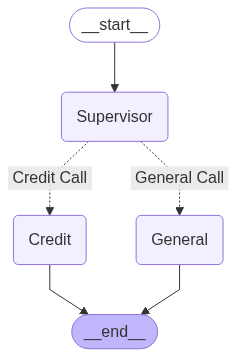

In [62]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
## pip install pandas, openpyxl

####### macro2 #######
from openpyxl import load_workbook
from datetime import date, datetime
from typing import Union

def convert_to_text_format_pivot(source_file: str) -> None:
    """
    Open the given workbook, and for each sheet:
    - Identify columns where less than half the non-empty cells are dates
      and apply a "Text to Columns" operation (splitting on tabs).
    - Leave date-heavy columns unchanged.

    This mutates the same file in place.
    """
    wb = load_workbook(filename=source_file)
    
    for ws in wb.worksheets:
        print(f"Processing sheet: {ws.title}")
        
        max_col = ws.max_column
        for c in range(max_col, 0, -1):
            if ws.cell(row=1, column=c).value not in (None, ""):
                last_col = c
                break
        else:
            continue
        
        max_row = ws.max_row
        for r in range(max_row, 0, -1):
            if ws.cell(row=r, column=1).value not in (None, ""):
                last_row = r
                break
        else:
            continue
        
        for col_idx in range(1, last_col + 1):
            date_count = 0
            total_cells = 0
            
            for row_idx in range(1, last_row + 1):
                cell = ws.cell(row=row_idx, column=col_idx)
                val = cell.value
                if val not in (None, ""):
                    total_cells += 1
                    if isinstance(val, (datetime, date)):
                        date_count += 1
            
            if total_cells > 0 and (date_count / total_cells) > 0.5:
                print(f"  → Skipping column {col_idx} (>{date_count}/{total_cells} dates)")
                continue
            
            print(f"  → Splitting column {col_idx} on tabs")
            for row_idx in range(1, last_row + 1):
                cell = ws.cell(row=row_idx, column=col_idx)
                val = cell.value
                if isinstance(val, str) and '\t' in val:
                    parts = val.split('\t')
                    for offset, part in enumerate(parts):
                        ws.cell(row=row_idx, column=col_idx + offset, value=part)
    
    wb.save(source_file)
    print("Done. Workbook saved.")

if __name__ == "__main__":
    path = r"C:\path\to\your\file.xlsx"
    convert_to_text_format_pivot(path)



In [ ]:

######## macro3 #######
from openpyxl import load_workbook
from openpyxl.styles import Border, Side
from openpyxl.utils import get_column_letter

def apply_borders_to_range(ws, cell_range):
    """
    Apply a thin black border around every cell in the given range.
    """
    thin = Side(border_style="thin", color="000000")
    border = Border(top=thin, left=thin, right=thin, bottom=thin)
    for row in ws[cell_range]:
        for cell in row:
            cell.border = border

def apply_borders_to_data(source_file: str):
    """
    Open the workbook at source_file, loop each sheet, detect
    data blocks (or fixed columns on 'Summary'), and apply borders.
    Saves changes in place.
    """
    wb = load_workbook(filename=source_file)
    for ws in wb.worksheets:
        last_row = 0
        for r in range(ws.max_row, 0, -1):
            if ws.cell(row=r, column=1).value is not None:
                last_row = r
                break
        if last_row == 0:
            continue  
        
        if ws.title == "Summary":
            for start, end in [("A", "F"), ("H", "J"), ("L", "R"), ("T", "Z")]:
                rng = f"{start}1:{end}{last_row}"
                apply_borders_to_range(ws, rng)
        else:
            last_col = ws.max_column
            col = 1
            while col <= last_col:
                has_data = any(
                    ws.cell(row=r, column=col).value is not None
                    for r in range(1, last_row + 1)
                )
                if has_data:
                    start_col = col
                    end_col = col
                    while (
                        end_col + 1 <= last_col
                        and any(
                            ws.cell(row=r, column=end_col + 1).value is not None
                            for r in range(1, last_row + 1)
                        )
                    ):
                        end_col += 1
                    cell_range = (
                        f"{get_column_letter(start_col)}1:"
                        f"{get_column_letter(end_col)}{last_row}"
                    )
                    apply_borders_to_range(ws, cell_range)
                    col = end_col + 1
                else:
                    col += 1
    wb.save(source_file)

if __name__ == "__main__":
    # Example usage:
    path_to_file = r"C:\path\to\your\workbook.xlsx"
    apply_borders_to_data(path_to_file)
    print("Borders applied and file saved.")

In [ ]:
##### macro4 ######
from openpyxl.styles import Border, Side

def apply_borders_to_range(ws, cell_range: str):
    """
    Apply a thin black continuous border around every cell in the given Excel-style range.
    If an error occurs, prints a message with the offending range.
    
    :param ws: openpyxl worksheet object
    :param cell_range: e.g. "A1:C10"
    """    
    thin_side = Side(border_style="thin", color="000000")
    border = Border(top=thin_side, bottom=thin_side, left=thin_side, right=thin_side)

    try:
        for row in ws[cell_range]:
            for cell in row:
                cell.border = border
    except Exception as e:
        print(f"Error applying borders to range {cell_range}: {e}")

from openpyxl import load_workbook

wb = load_workbook("your_file.xlsx")
ws = wb["Sheet1"]
apply_borders_to_range(ws, "A1:F20")
wb.save("your_file.xlsx")



In [ ]:
####### macro5 ########
from openpyxl import load_workbook
from openpyxl.styles import numbers
from openpyxl.utils import get_column_letter
from datetime import datetime, date

def auto_amount(source_file: str) -> None:
    """
    Open the workbook at source_file and for each sheet:
      1. Find the last used column in row 1.
      2. For each column i:
         - If the header (row 1) or the second cell (row 2) contains “Amount” (case-insensitive):
             • Split any tab-delimited text in that column into successive columns
               (mimicking Excel’s TextToColumns with Tab delimiter).
             • Apply a “comma” number format (#,##0.00) to numeric cells in that column.
      3. Approximate an AutoFit by setting each column’s width to its longest cell + padding.
    Saves changes back to source_file.
    """
    wb = load_workbook(filename=source_file)
    
    for ws in wb.worksheets:
        last_col = 0
        for col in range(ws.max_column, 0, -1):
            if ws.cell(row=1, column=col).value not in (None, ""):
                last_col = col
                break
        if last_col == 0:
            continue

        max_row = ws.max_row

        for col_idx in range(1, last_col + 1):
            header_val = ws.cell(row=1, column=col_idx).value
            check_val  = ws.cell(row=2, column=col_idx).value
            
            if any(
                isinstance(v, str) and "amount" in v.lower()
                for v in (header_val, check_val)
            ):
                for row_idx in range(1, max_row + 1):
                    cell = ws.cell(row=row_idx, column=col_idx)
                    if isinstance(cell.value, str) and "\t" in cell.value:
                        parts = cell.value.split("\t")
                        for offset, part in enumerate(parts):
                            ws.cell(row=row_idx, column=col_idx + offset, value=part)
                
                for row_idx in range(1, max_row + 1):
                    cell = ws.cell(row=row_idx, column=col_idx)
                    if isinstance(cell.value, (int, float)):
                        cell.number_format = numbers.FORMAT_NUMBER_COMMA_SEPARATED1

        for col_cells in ws.columns:
            col_letter = get_column_letter(col_cells[0].column)
            max_length = max(
                (len(str(cell.value)) for cell in col_cells if cell.value not in (None, "")),
                default=0
            )
            ws.column_dimensions[col_letter].width = max_length + 2

    wb.save(source_file)


if __name__ == "__main__":
    path = r"C:\path\to\your\workbook.xlsx"
    auto_amount(path)
    print("Finished processing. Workbook saved.")


In [ ]:
####### macro6 ########

from openpyxl import load_workbook
from openpyxl.utils import column_index_from_string

def smmis(source_file: str) -> None:
    """
    Replicates the VBA SMMIS macro in Python:
      1. Opens the workbook and grabs the first sheet.
      2. “Pastes values” over every column (i.e. drops formulas, keeps cached values).
      3. For columns D, E, and G: keeps only the text up to the first tab (TextToColumns with Tab and FieldInfo=[(1,Text)]).
      4. Takes the cell C10, splits on Tab, writes the first piece into J1, and sets J1’s number_format to yyyy/mm/dd.
      5. Likewise for C11 → K1.
      6. Removes all commas from every text cell.
      7. Deletes columns T:AN.
      8. Writes “Insertion_Date” into T1.
      9. Saves changes back to the same file.
    """

    wb = load_workbook(filename=source_file, data_only=True)
    ws = wb.worksheets[0]

    last_row = ws.max_row
    last_col = 0
    for c in range(ws.max_column, 0, -1):
        if ws.cell(row=1, column=c).value not in (None, ""):
            last_col = c
            break


    for col_idx in range(1, last_col + 1):
        for row_idx in range(1, last_row + 1):
            cell = ws.cell(row=row_idx, column=col_idx)
            cell.value = cell.value


    for letter in ("D", "E", "G"):
        col_idx = column_index_from_string(letter)
        for row_idx in range(1, last_row + 1):
            cell = ws.cell(row=row_idx, column=col_idx)
            if isinstance(cell.value, str):
                cell.value = cell.value.split("\t", 1)[0]


    src_c10 = ws.cell(row=10, column=3).value
    if src_c10 is not None:
        part = str(src_c10).split("\t", 1)[0]
        dest = ws.cell(row=1, column=column_index_from_string("J"))
        dest.value = part
        dest.number_format = "yyyy/mm/dd"


    src_c11 = ws.cell(row=11, column=3).value
    if src_c11 is not None:
        part = str(src_c11).split("\t", 1)[0]
        dest = ws.cell(row=1, column=column_index_from_string("K"))
        dest.value = part
        dest.number_format = "yyyy/mm/dd"

    for _ in range(2):
        for row in ws.iter_rows(min_row=1, max_row=last_row,
                                 min_col=1, max_col=last_col):
            for cell in row:
                if isinstance(cell.value, str) and "," in cell.value:
                    cell.value = cell.value.replace(",", "")


    start = column_index_from_string("T")
    end   = column_index_from_string("AN")

    for col_idx in range(end, start - 1, -1):
        ws.delete_cols(col_idx)

    ws.cell(row=1, column=start, value="Insertion_Date")

    wb.save(source_file)


In [ ]:
####### macro7 #######
from openpyxl import load_workbook
from openpyxl.styles import Border, Side
from openpyxl.utils import get_column_letter, column_index_from_string

def smfile(source_file: str) -> None:
    """
    Replicates the VBA SMFILE macro in Python:
      1. Opens the workbook and grabs the first sheet.
      2. Finds the used range (1,1) to (lastRow,lastCol).
      3. Applies a thin black border on all four sides of every cell
         (which covers both the outer edges and inner gridlines).
      4. Deletes column BD.
      5. Auto-sizes each column to fit its contents.
      6. Saves the workbook in place.
    """

    wb = load_workbook(filename=source_file)
    ws = wb.worksheets[0]

    last_row = 0
    for r in range(ws.max_row, 0, -1):
        if ws.cell(row=r, column=1).value not in (None, ""):
            last_row = r
            break

    last_col = 0
    for c in range(ws.max_column, 0, -1):
        if ws.cell(row=1, column=c).value not in (None, ""):
            last_col = c
            break

    if last_row == 0 or last_col == 0:

        wb.save(source_file)
        return


    thin = Side(border_style="thin", color="000000")
    border = Border(left=thin, right=thin, top=thin, bottom=thin)

    for row in ws.iter_rows(min_row=1, max_row=last_row,
                             min_col=1, max_col=last_col):
        for cell in row:
            cell.border = border


    bd_idx = column_index_from_string("BD")
    ws.delete_cols(bd_idx)


    for column_cells in ws.columns:
        col_letter = get_column_letter(column_cells[0].column)
        max_len = max(
            (len(str(cell.value)) for cell in column_cells if cell.value not in (None, "")),
            default=0
        )
        ws.column_dimensions[col_letter].width = max_len + 2

    wb.save(source_file)


if __name__ == "__main__":
    path = r"C:\path\to\your\workbook.xlsx"
    smfile(path)
    print("SMFILE processing complete. Workbook saved.")
